In [410]:
# relevant libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")


In [411]:
trajectory = gpd.read_file('../scratch/traj.geojson')
picks = gpd.read_file('../scratch/picks.geojson')


In [412]:
def categorize_location(df):
    """
    Categorizes the location based on the given conditions.

    Args:
        df (DataFrame): The input DataFrame containing the location information.

    Returns:
        DataFrame: The DataFrame with the 'location' column updated based on the conditions.
    """

    df['location'] = 'other'
    df['location'] = np.where(df['dense_urban_sidewalk'] == 1, 'dense_urban_sidewalk', df['location'])
    df['location'] = np.where(df['neighborhood_sidewalk'] == 1, 'neighborhood_sidewalk', df['location'])
    df['location'] = np.where(df['park'] == 1, 'park', df['location'])
    df['location'] = np.where(df['country_side'] == 1, 'country_side', df['location'])
    df = df[df['location'] != 'other']
    return df

def categorize_picks(picks):
    """
    Categorizes the picks based on different types of waste.

    Args:
        picks (DataFrame): The DataFrame containing the picks data.

    Returns:
        DataFrame: The DataFrame with an additional 'category' column indicating the category of each pick.
    """

    picks['category'] = 'other'
    picks['category'] = np.where(picks['food_packaging'] == 1, 'food_packaging', picks['category'])
    picks['category'] = np.where(picks['general_packaging'] == 1, 'general_packaging', picks['category'])
    picks['category'] = np.where(picks['recycle_waste'] == 1, 'recycle_waste', picks['category'])
    picks['category'] = np.where(picks['waste_printed_information'] == 1, 'waste_printed_information', picks['category'])
    picks['category'] = np.where(picks['cigarette_waste'] == 1, 'cigarette_waste', picks['category'])
    picks['category'] = np.where(picks['other_waste'] == 1, 'other_waste', picks['category'])
    picks['category'] = np.where(picks['chewing_gum_waste'] == 1, 'chewing_gum_waste', picks['category'])

    # remove other from category column
    picks = picks[picks['category'] != 'other']
    
    return picks

def set_min_max_time(picks, limit):
    """
    Sets the minimum and maximum time values for each pick in the given DataFrame.

    Parameters:
    picks (DataFrame): The DataFrame containing the pick data.
    limit (int): The time limit in seconds.

    Returns:
    DataFrame: The DataFrame with the 'min_time' and 'max_time' columns added.
    """

    picks['min_time'] = picks['date_taken'] - pd.Timedelta(seconds=limit)
    picks['max_time'] = picks['date_taken'] + pd.Timedelta(seconds=limit)
    
    return picks

def create_Trajectory_object(traj_gdf):
    """
    Create a Trajectory object from a GeoDataFrame.

    Parameters:
    traj_gdf (GeoDataFrame): A GeoDataFrame containing trajectory data.

    Returns:
    trajectory (GeoDataFrame): A GeoDataFrame representing the trajectory object.
    """

    trajectory = mpd.Trajectory(traj_gdf, traj_id='traj_id', t='t')
    trajectory.add_acceleration()
    trajectory.add_speed()
    trajectory.add_distance()
    trajectory = trajectory.to_point_gdf()

    # Reset the index of the GeoDataFrame
    trajectory.reset_index(inplace=True)

    return trajectory


def points_within_limit(pick_point, points, limit):
    """
    Returns the subset of points that are within a certain distance limit from a given pick point.

    Parameters:
    pick_point (Point): The pick point from which the distance is calculated.
    points (GeoDataFrame): The GeoDataFrame containing the points to filter.
    limit (float): The distance limit in kilometers.

    Returns:
    GeoDataFrame: The subset of points that are within the distance limit.
    """
    # Convert limit from kilometers to degrees (approximately)
    limit_in_degrees = limit / 111
    return points[points.geometry.distance(pick_point) <= limit_in_degrees]

def detect_outliers(data):
    """
    Detects outliers in a given dataset using the Interquartile Range (IQR) method.

    Parameters:
    data (list or numpy array): The dataset to be analyzed.

    Returns:
    dict: A dictionary containing the indices and values of the detected outliers.
    """

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = 0
    upper_bound = Q3 + 1.5 * IQR
    outliers = {i: x for i, x in enumerate(data) if x < lower_bound or x > upper_bound}
    return outliers

def overlaps(current, previous, next):
    """
    Checks if the time range of the current data overlaps with the time ranges of the previous and next data.

    Parameters:
    current (dict): The current data with 'min_time' and 'max_time' keys representing the time range.
    previous (dict): The previous data with 'min_time' and 'max_time' keys representing the time range.
    next (dict): The next data with 'min_time' and 'max_time' keys representing the time range.

    Returns:
    bool: True if there is an overlap, False otherwise.
    """
    if previous is not None and current['min_time'] < previous['max_time']:
        return True
    if next is not None and current['max_time'] > next['min_time']:
        return True
    return False



def percentage_overlap(previous, current, next, timeframe):
    """
    Calculates the percentage overlap of the current timeframe with the previous and next timeframes.

    Parameters:
    previous (dict): The previous data with 'min_time' and 'max_time' keys representing the time range.
    current (dict): The current data with 'min_time' and 'max_time' keys representing the time range.
    next (dict): The next data with 'min_time' and 'max_time' keys representing the time range.

    Returns:
    float: The percentage overlap of the current timeframe with the previous and next timeframes.
    """

    overlap = 0
    if previous is not None:
        overlap += (previous['max_time'] - current['min_time']).total_seconds()

    if next is not None:
        overlap += (current['max_time'] - next['min_time']).total_seconds()

    return overlap / timeframe * 100

    



# function that takes the min and max time of a pick and returns the points in the trajectory that are within that time frame
def points_within_timeframe(pick, points):
    return points[(points['t'] >= pick['min_time']) & (points['t'] <= pick['max_time'])]

def plot_cumulative_distance_df(df, trajectory):
    """
    Plots the cumulative distance and cumulative median distance for each pick in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - trajectory (Trajectory): The trajectory data.

    Returns:
    - None

    """
    # Determine the number of rows needed for the subplots
    n = len(df)
    rows = int(np.ceil(n / 4))

    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Loop over each pick in all_picks
    for i, (pick, ax) in enumerate(zip(df.iterrows(), axs)):
        _, pick = pick

        points = points_within_timeframe(pick, trajectory)

        # Split the DataFrame into two parts at the pick point time
        before_pick = points[points['t'] <= pick['date_taken']]
        after_pick = points[points['t'] > pick['date_taken']]

        # Calculate the cumulative distance separately for each part
        before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
        after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

        before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
        after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

        # Concatenate the two parts
        points = pd.concat([before_pick, after_pick])

        # Create a line plot for each pick on the respective subplot
        ax.plot(points['t'], points['cumulative_distance'])
        ax.plot(points['t'], points['cumulative_median_distance'])
        
        # Fill the areas under and above the lines with different colors
        ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                        where=(points['cumulative_distance'] > points['cumulative_median_distance']), 
                        color='green', alpha=0.3)
        ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                        where=(points['cumulative_distance'] <= points['cumulative_median_distance']), 
                        color='red', alpha=0.3)

        ax.set_ylabel('cumulative distance to pick (m)')
        ax.set_xlabel('time (s)')
        ax.set_title(f'Pick {pick["id"]}')
        
        # Highlight the time of the pick with a vertical red line
        ax.axvline(x=pick['date_taken'], color='red')
        
        # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

        # Set the y-axis limit to 120
        ax.set_ylim(0, )

    # Remove unused subplots
    for i in range(n, rows*4):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

def points_within_timeframe(pick, trajectory):
    """
    Filter the trajectory data to include only the points within the timeframe of the given pick.

    Args:
        pick: The pick data.
        trajectory: The trajectory data.

    Returns:
        pd.DataFrame: The filtered trajectory data.
    """
    return trajectory[(trajectory['t'] >= pick['min_time']) & (trajectory['t'] <= pick['max_time'])]

def plot_cumulative_distance_pick(pick, trajectory):
    """
    Plots the cumulative distance to a pick point over time.

    Parameters:
    - pick (DataFrame): The pick point information.
    - trajectory (DataFrame): The trajectory data.

    Returns:
    None
    """

    # Create a figure and axes for the subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    points = points_within_timeframe(pick, trajectory)

    # Split the DataFrame into two parts at the pick point time
    before_pick = points[points['t'] <= pick['date_taken']]
    after_pick = points[points['t'] > pick['date_taken']]

    # Calculate the cumulative distance separately for each part
    before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
    after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

    before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
    after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

    # Concatenate the two parts
    points = pd.concat([before_pick, after_pick])

    # Create a line plot for the pick
    ax.plot(points['t'], points['cumulative_distance'])
    ax.plot(points['t'], points['cumulative_median_distance'])

    # Fill the areas under and above the lines with different colors
    ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                    where=(points['cumulative_distance'] > points['cumulative_median_distance']), 
                    color='green', alpha=0.3)
    ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                    where=(points['cumulative_distance'] <= points['cumulative_median_distance']), 
                    color='red', alpha=0.3)

    ax.set_ylabel('cumulative distance to pick (m)')
    ax.set_xlabel('time (s)')
    ax.set_title(f'Pick {pick["id"]}')

    # Highlight the time of the pick with a vertical red line
    ax.axvline(x=pick['date_taken'], color='red')

    # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

    plt.tight_layout()
    plt.show()

def plot_acceleration(non_overlapping_picks, trajectory):
    """
    Plots the acceleration data for each pick in the given non_overlapping_picks DataFrame
    on separate subplots.

    Parameters:
    - non_overlapping_picks (DataFrame): DataFrame containing pick data
    - trajectory (DataFrame): DataFrame containing trajectory data

    Returns:
    None
    """

    # Determine the number of rows needed for the subplots
    n = len(non_overlapping_picks)
    rows = int(np.ceil(n / 4))

    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Loop over each pick in non_overlapping_picks
    for i, (pick, ax) in enumerate(zip(non_overlapping_picks.iterrows(), axs)):
        _, pick = pick
        points = points_within_timeframe(pick, trajectory)

        # Create a scatter plot for each pick on the respective subplot
        ax.scatter(points['t'], points['acceleration'])
        ax.set_ylabel('accelearation (m/s^2)')
        ax.set_xlabel('time (s)')
        ax.set_title(f'Pick {pick["id"]}')

        # Highlight the time of the pick with a vertical red line
        ax.axvline(x=pick['date_taken'], color='red')

        # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

    # Remove unused subplots
    for i in range(n, rows*4):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

def calculate_extra_time(picks, trajectory, normal_pace):
    """
    Calculates the extra time taken for each pick based on the trajectory and normal pace.

    Args:
        picks (DataFrame): DataFrame containing pick information.
        trajectory (DataFrame): DataFrame containing trajectory information.
        normal_pace (float): Normal pace of the person.

    Returns:
        DataFrame: DataFrame with the 'extra_time' column updated for each pick.
    """
    for i, pick in picks.iterrows():
        if pick['outlier'] == False:
            points = points_within_timeframe(pick, trajectory)
            # Split the DataFrame into two parts at the pick point time
            before_pick = points[points['t'] <= pick['date_taken']]
            after_pick = points[points['t'] > pick['date_taken']]

            # Calculate the cumulative distance separately for each part
            before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
            after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

            before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
            after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

            actual_distance = before_pick['cumulative_distance'].max() + after_pick['cumulative_distance'].max()

            expected_distance = before_pick['cumulative_median_distance'].max() + after_pick['cumulative_median_distance'].max()

            # Modify the 'extra_time' column in the 'picks' DataFrame directly
            picks.loc[i, 'extra_time'] = (expected_distance - actual_distance) / normal_pace

    # Remove negative values
    picks = picks[picks['extra_time'] >= 0]
    
    return picks

In [413]:
crs = "EPSG:4326"  # WGS84 latitude-longitude projection
timeframe = 10 # seconds
datetime_col = 'date_taken'
limit = 0.01  # 0.01 kilometers = 10 meters
normal_pace = 1.7


In [414]:
picks = categorize_location(picks)
picks = categorize_picks(picks)
picks = set_min_max_time(picks, timeframe)

In [415]:
# Set the same CRS for both GeoDataFrames
trajectory.crs = crs
picks.crs = crs

# Create a Trajectory object from the GeoDataFrame
trajectory = create_Trajectory_object(trajectory)
trajectory['normal_pace'] = normal_pace


# Find points within a certain distance from a pick point
id = 0
pick_point = picks.geometry[id]  # Use the first pick point as an example
nearby_points = points_within_limit(pick_point, trajectory, limit)

print(f'Number of points within {limit} km from the first pick point: {len(nearby_points)}')

Number of points within 0.01 km from the first pick point: 12


In [416]:
# find min and max time of the trajectory and the picks
print(f'Trajectory time range: {trajectory.t.min()} - {trajectory.t.max()}')
print(f'Picks time range: {picks.date_taken.min()} - {picks.date_taken.max()}')


Trajectory time range: 2023-08-19 10:08:43 - 2023-08-19 16:22:21
Picks time range: 2023-08-19 10:12:31 - 2023-08-19 16:19:32


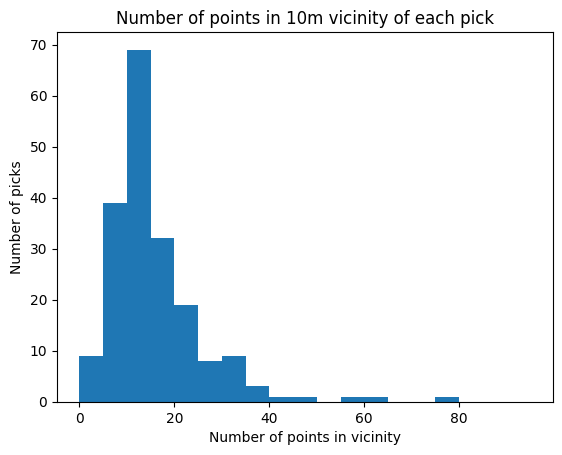

In [417]:
# make histogram of num points in vicinity of each pick
num_points_in_vicinity = []
for pick_point in picks.geometry:
    nearby_points = points_within_limit(pick_point, trajectory, limit)
    num_points_in_vicinity.append(len(nearby_points))

plt.hist(num_points_in_vicinity, bins=range(0, 100, 5))
plt.xlabel('Number of points in vicinity')
plt.ylabel('Number of picks')
plt.title('Number of points in 10m vicinity of each pick')
plt.show()


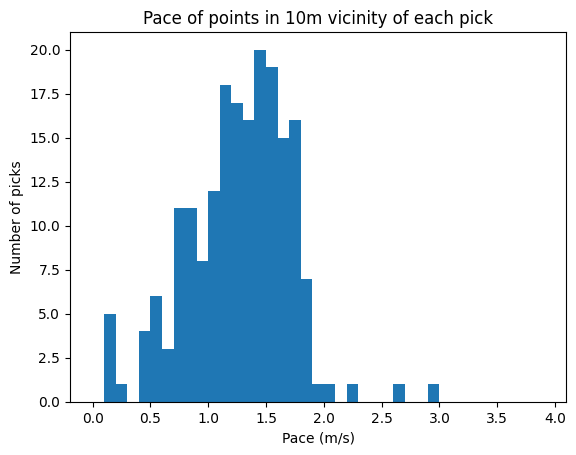

In [418]:
# find pace of points in vicinity of each pick
pace_in_vicinity = []
for pick_point in picks.geometry:
    nearby_points = points_within_limit(pick_point, trajectory, limit)
    pace_in_vicinity.append(pd.to_numeric(nearby_points['speed']).mean())


plt.hist(pace_in_vicinity, bins=np.arange(0,4,.1))
plt.xlabel('Pace (m/s)')
plt.ylabel('Number of picks')
plt.title('Pace of points in 10m vicinity of each pick')
plt.show()


1.2898965575086143


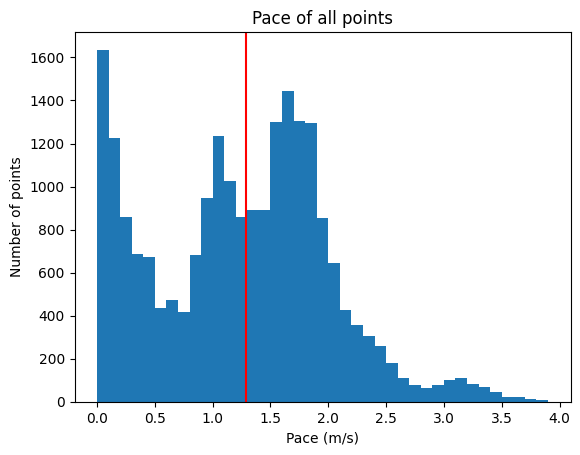

In [419]:
# create hist of pace num of picks all picks
pace = pd.to_numeric(trajectory['speed']).median()
print(pace)

plt.hist(pd.to_numeric(trajectory['speed']), bins=np.arange(0,4,.1))
plt.axvline(trajectory['speed'].median(), color='r')
plt.xlabel('Pace (m/s)')
plt.ylabel('Number of points')
plt.title('Pace of all points')
plt.show()


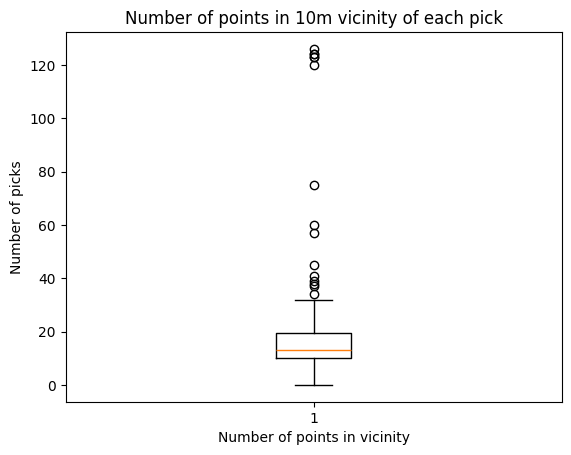

In [420]:
plt.boxplot(num_points_in_vicinity)
plt.xlabel('Number of points in vicinity')
plt.ylabel('Number of picks')
plt.title('Number of points in 10m vicinity of each pick')
plt.show()

In [421]:
outliers = detect_outliers(num_points_in_vicinity)

In [422]:
print(f'Outliers in number of points in vicinity: {detect_outliers(num_points_in_vicinity)}')
print(f'amount of outliers: {len(outliers)}')

Outliers in number of points in vicinity: {13: 45, 14: 75, 59: 120, 62: 38, 120: 60, 148: 57, 153: 34, 155: 123, 156: 123, 157: 124, 158: 124, 159: 126, 177: 39, 190: 37, 194: 41}
amount of outliers: 15


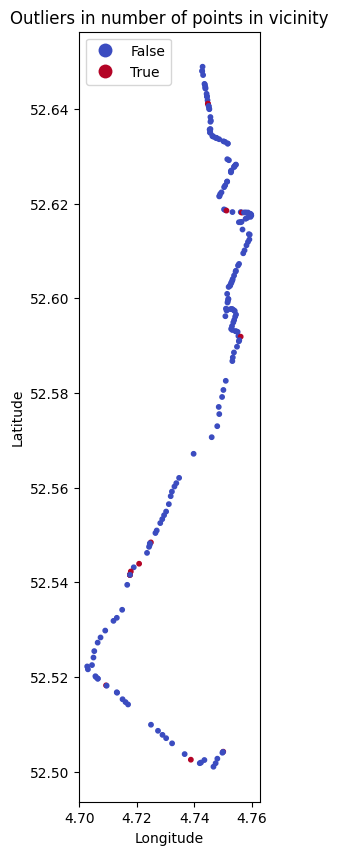

In [423]:
# add outlier column to picks
picks['outlier'] = False

for i in outliers:
    picks.at[i, 'outlier'] = True

# plot the outliers
picks.plot(column='outlier', legend=True, cmap='coolwarm', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Outliers in number of points in vicinity')
plt.show()


In [424]:
picks.shape

(199, 25)

In [425]:
# find overlapping timeframes
picks['overlapping'] = True

for i, pick in picks.iterrows():
    previous = picks.iloc[i-1] if i > 0 else None
    next = picks.iloc[i+1] if i < len(picks)-1 else None
    if i > 0 and i < len(picks) and overlaps(pick, previous, next):
        picks.at[i, 'overlapping'] = False


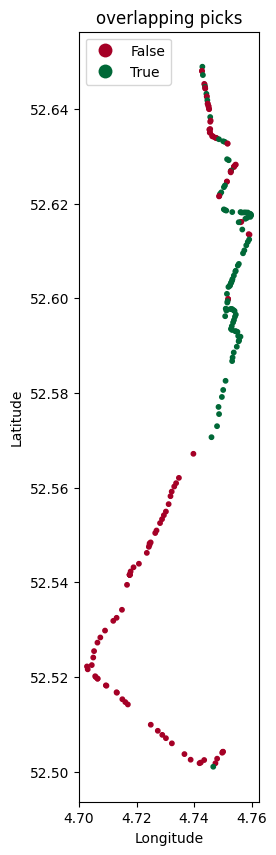

In [426]:
# plot the non-overlapping picks
picks.plot(column='overlapping', legend=True, cmap='RdYlGn', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('overlapping picks')
plt.show()


In [427]:
# print min time and max time of last 10 picks
print(picks[['min_time', 'max_time', 'overlapping']].tail(10))

               min_time            max_time  overlapping
190 2023-08-19 15:49:30 2023-08-19 15:49:50        False
191 2023-08-19 15:53:11 2023-08-19 15:53:31        False
192 2023-08-19 15:58:59 2023-08-19 15:59:19        False
193 2023-08-19 16:00:02 2023-08-19 16:00:22        False
194 2023-08-19 16:09:51 2023-08-19 16:10:11        False
195 2023-08-19 16:10:15 2023-08-19 16:10:35        False
196 2023-08-19 16:10:55 2023-08-19 16:11:15        False
197 2023-08-19 16:16:42 2023-08-19 16:17:02        False
198 2023-08-19 16:18:10 2023-08-19 16:18:30        False
199 2023-08-19 16:19:22 2023-08-19 16:19:42         True


In [428]:
from datetime import datetime

def percentage_overlap(current, previous, next, timeframe):
    """
    Calculates the percentage overlap between the current data and the previous and next data.

    Parameters:
    current (dict): The current data with 'min_time' and 'max_time' keys representing the time range.
    previous (dict): The previous data with 'min_time' and 'max_time' keys representing the time range. Can be None.
    next (dict): The next data with 'min_time' and 'max_time' keys representing the time range. Can be None.
    timeframe (int): The total timeframe.

    Returns:
    float: The percentage overlap between the current data and the previous and next data.
    """
    overlap = 0
    if previous is not None and current['min_time'] < previous['max_time']:
        overlap += (min(current['max_time'], previous['max_time']) - current['min_time']).total_seconds()
    if next is not None and current['max_time'] > next['min_time']:
        overlap += (current['max_time'] -  next['min_time']).total_seconds()
    return overlap / (timeframe * 2) * 100

picks['percentage_overlap'] = 0

# Calculate the percentage overlap for each pick
for i, pick in picks.iterrows():
    previous = picks.iloc[i-1] if i > 0 else None
    next = picks.iloc[i+1] if i < len(picks)-1 else None
    picks.loc[i, 'percentage_overlap'] = percentage_overlap(pick, previous, next, timeframe)

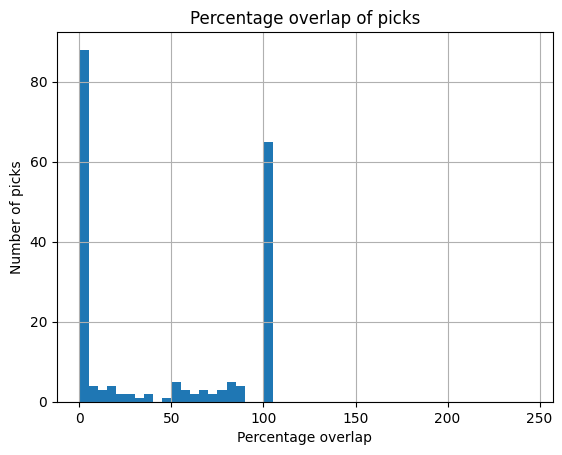

In [429]:
picks['percentage_overlap'].hist(bins=range(0, 250, 5))
plt.xlabel('Percentage overlap')
plt.ylabel('Number of picks')
plt.title('Percentage overlap of picks')
plt.show()


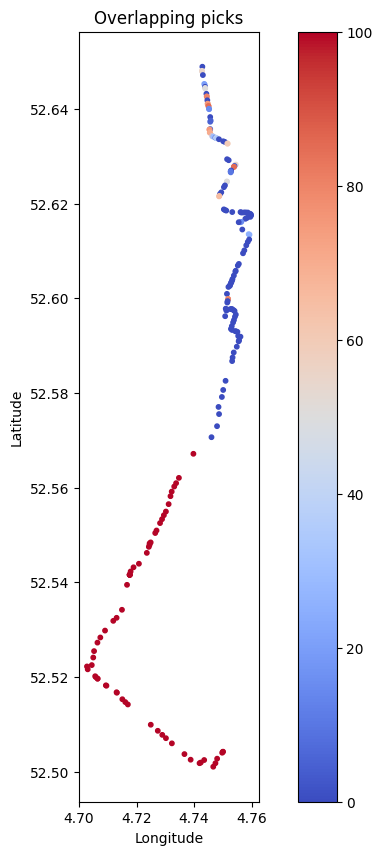

In [430]:
# plot the overlapping picks
picks.plot(column='percentage_overlap', legend=True, cmap='coolwarm', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Overlapping picks')
plt.show()


In [431]:
print(f'Number of picks with less than 50% overlap: {len(picks[picks["percentage_overlap"] < 50])}')
print(f'Number of picks with 0% overlap: {len(picks[picks["percentage_overlap"] == 0])}')
print(f'Number of picks with 100% overlap: {len(picks[picks["percentage_overlap"] >= 100])}')

Number of picks with less than 50% overlap: 107
Number of picks with 0% overlap: 88
Number of picks with 100% overlap: 65


In [432]:
# remove outliers from non-overlapping picks
non_overlapping_picks = picks[picks['overlapping'] == False]
non_overlapping_picks = non_overlapping_picks[non_overlapping_picks['outlier'] == False]

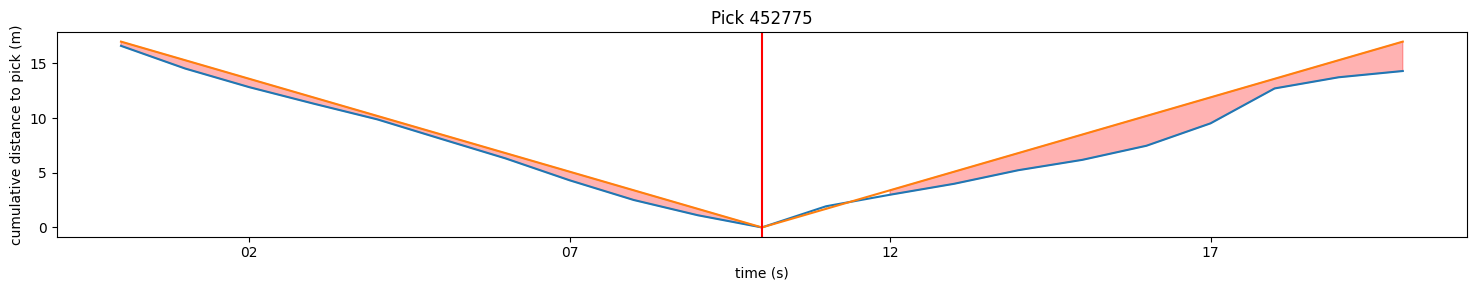

In [433]:
pick = non_overlapping_picks.iloc[0]
plot_cumulative_distance_pick(pick, trajectory)

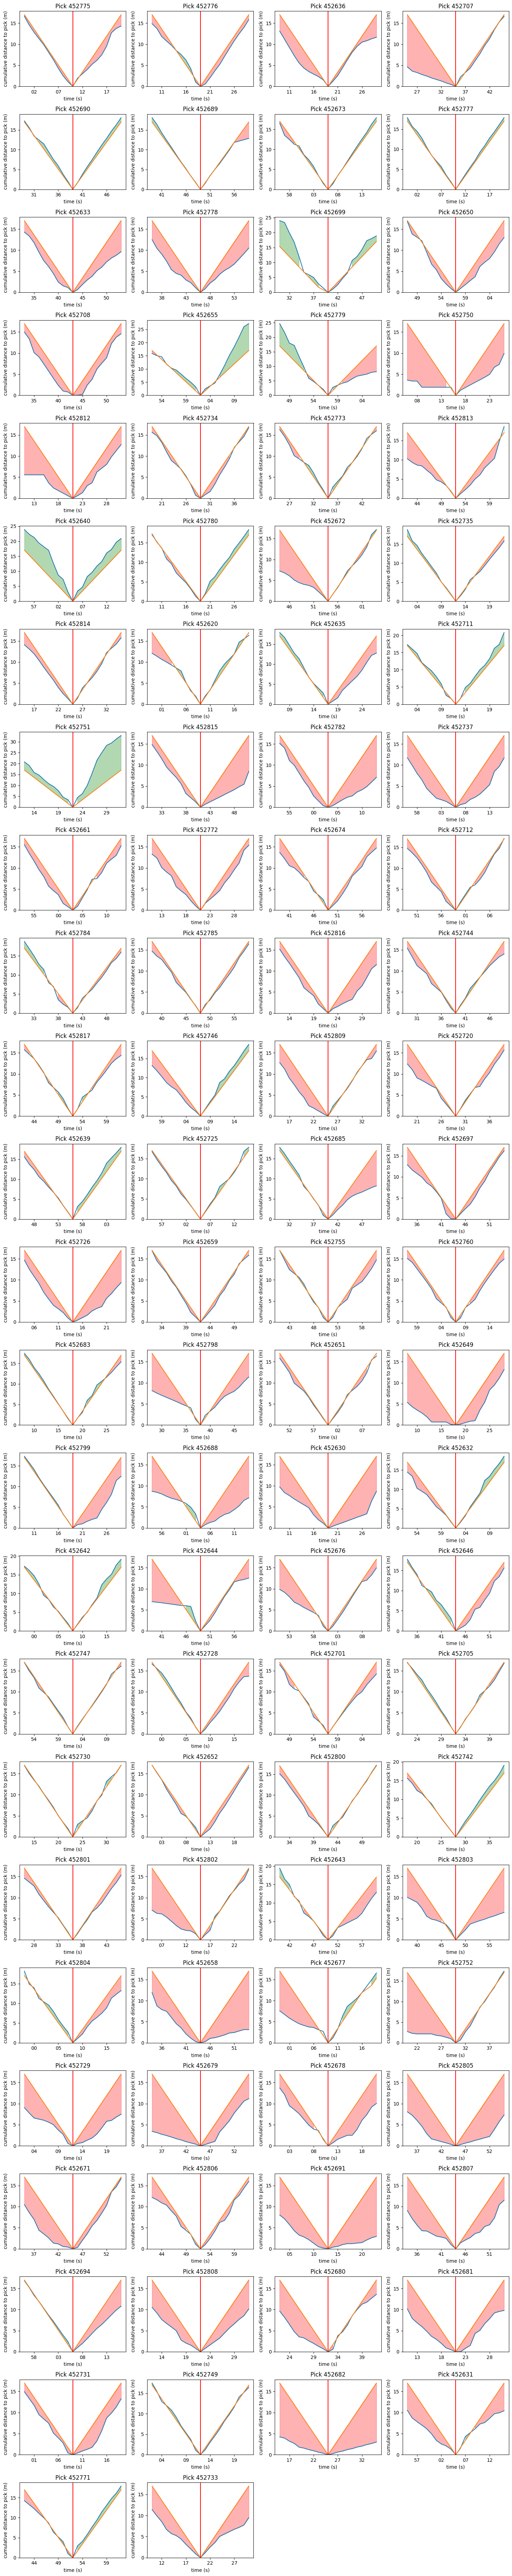

In [434]:
plot_cumulative_distance_df(non_overlapping_picks, trajectory)

In [435]:
# all the points in the trajectory that are within the time frame of the first non-overlapping pick
# plot_cumulative_distance_df(overlapping_picks, trajectory)

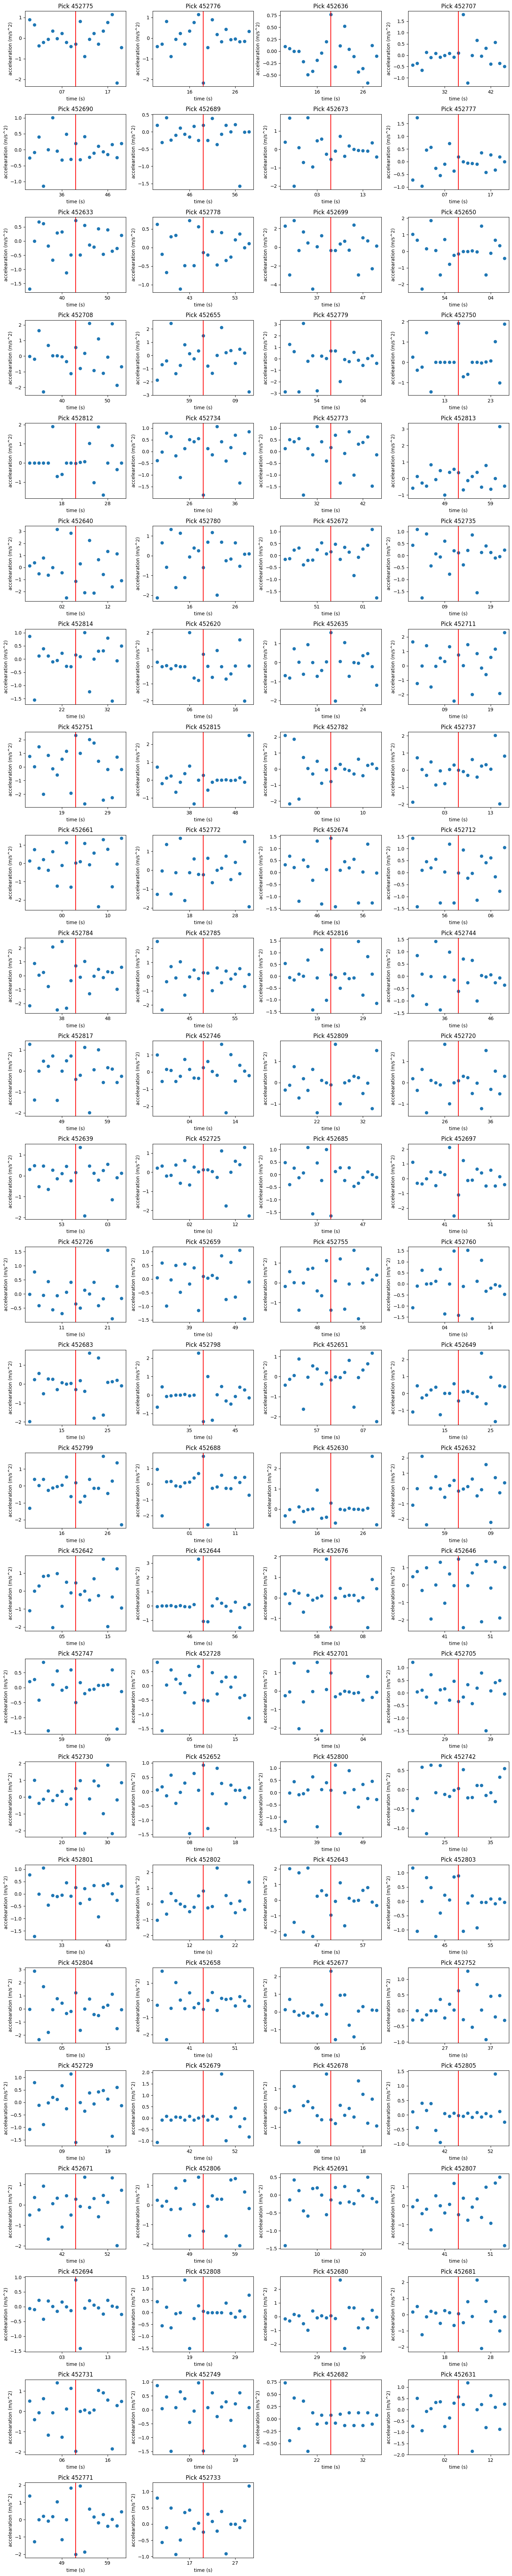

In [436]:
plot_acceleration(non_overlapping_picks, trajectory)

In [437]:
picks = calculate_extra_time(picks, trajectory, normal_pace)
non_overlapping_picks = calculate_extra_time(non_overlapping_picks, trajectory, normal_pace)

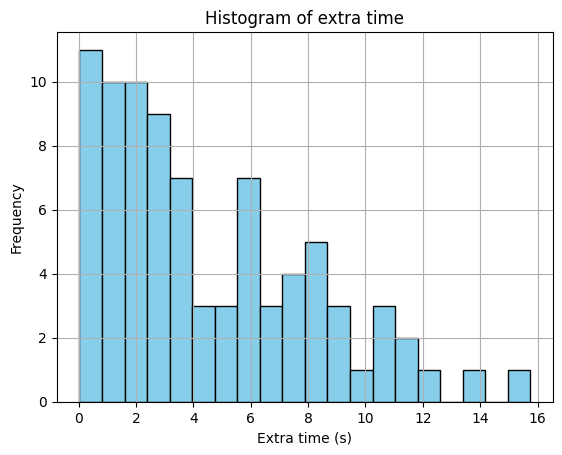

In [438]:
# Plot a histogram of the extra time
non_overlapping_picks['extra_time'].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1)
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.title('Histogram of extra time')
plt.show()



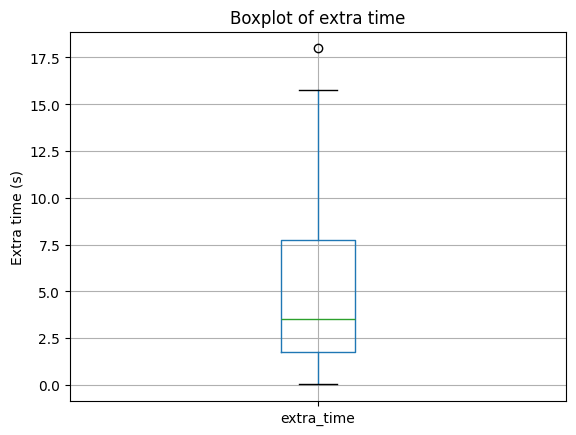

In [439]:
# make a boxplot of the extra time
picks.boxplot(column='extra_time')
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time')
plt.show()


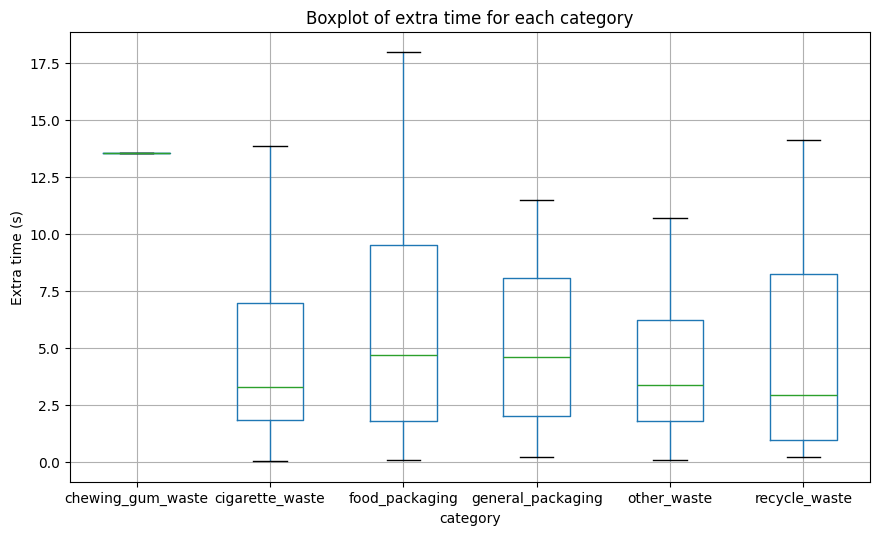

In [440]:
# Plot a boxplot of the extra time for each category
picks.boxplot(column='extra_time', by='category', figsize=(10, 6))
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time for each category')
plt.suptitle('')
plt.show()


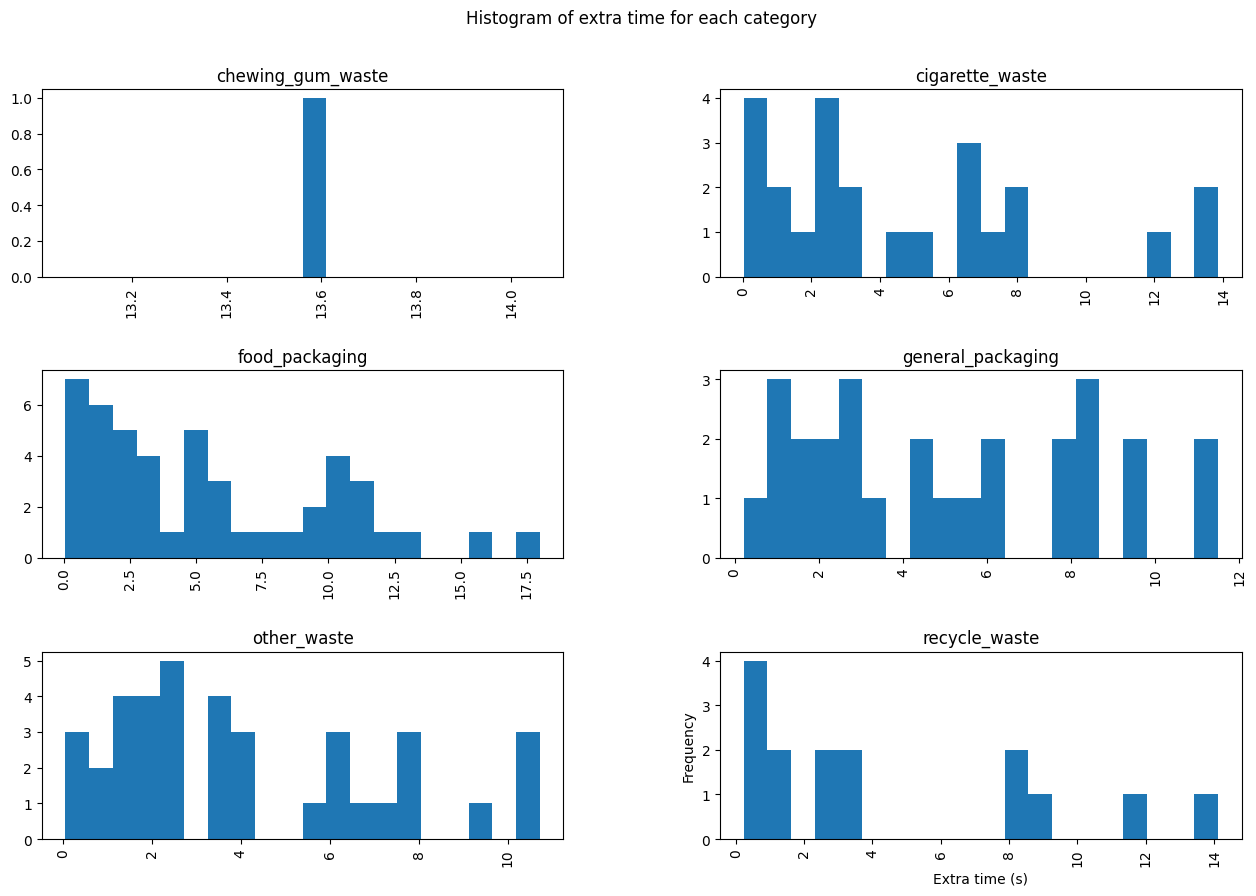

In [441]:
# histogram of extra time for each category
picks.hist(column='extra_time', by='category', bins=20, figsize=(15, 10))
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.suptitle('Histogram of extra time for each category')
plt.show()


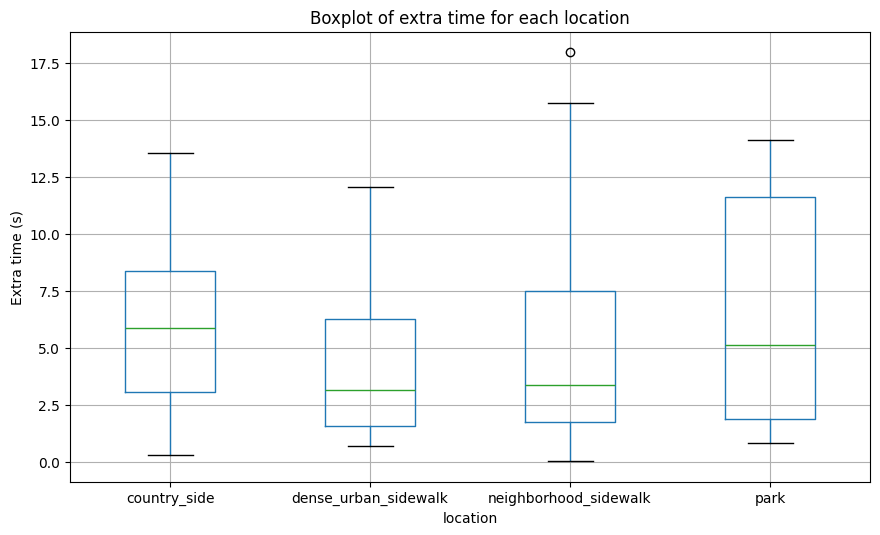

In [442]:
# Plot a boxplot of the extra time for each location
picks.boxplot(column='extra_time', by='location', figsize=(10, 6))
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time for each location')
plt.suptitle('')
plt.show()


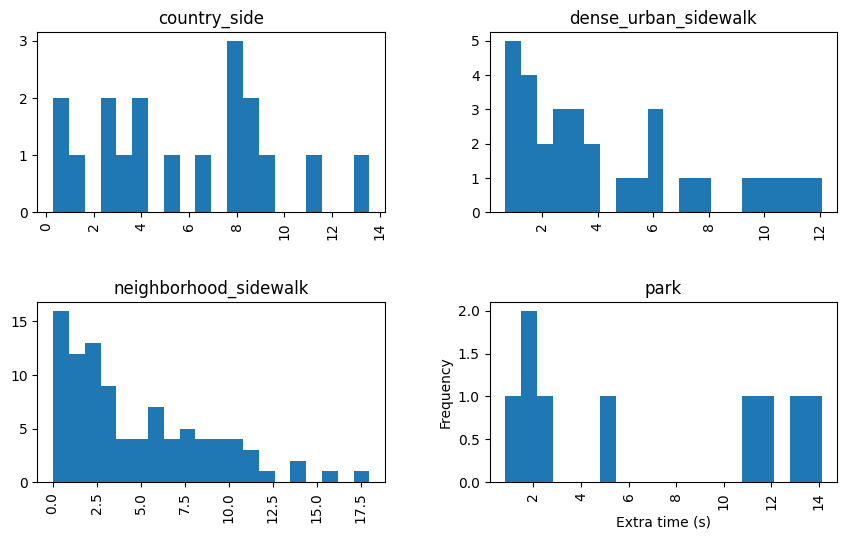

In [443]:
# histogram of extra time for each location
picks.hist(column='extra_time', by='location', bins=20, figsize=(10, 6))
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.suptitle('')
plt.show()


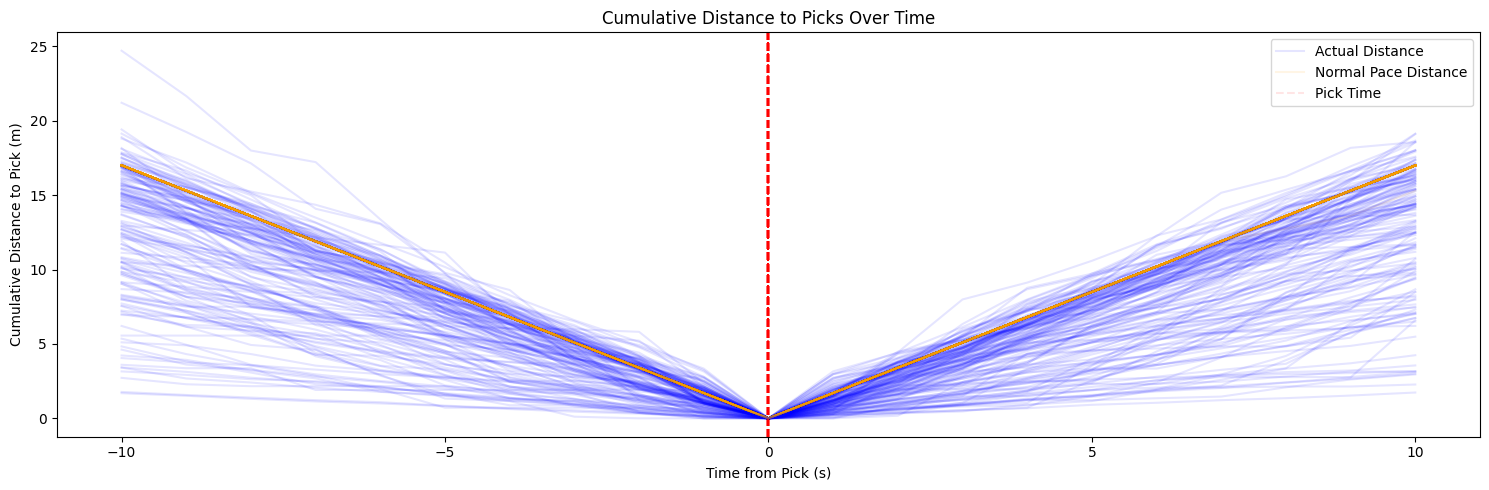

In [450]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

def plot_all_cumulative_distance_pick(all_picks, trajectory):
    """
    Plots the cumulative distance to multiple pick points over time.

    Parameters:
    - all_picks (DataFrame): The pick point information.
    - trajectory (DataFrame): The trajectory data.

    Returns:
    None
    """
    # Create a figure and axes for the subplot
    fig, ax = plt.subplots(figsize=(15, 5))

    for idx, pick in all_picks.iterrows():
        points = points_within_timeframe(pick, trajectory)

        # Normalize the time so that the pick time is zero
        points['normalized_time'] = (points['t'] - pick['date_taken']).dt.total_seconds()

        # Split the DataFrame into two parts at the pick point time
        before_pick = points[points['normalized_time'] <= 0]
        after_pick = points[points['normalized_time'] > 0]

        # Calculate the cumulative distance separately for each part
        before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
        after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

        before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
        after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

        # Concatenate the two parts
        points = pd.concat([before_pick, after_pick])

        # Create line plots for the cumulative distances with alpha value
        ax.plot(points['normalized_time'], points['cumulative_distance'], alpha=0.1, color='blue')
        ax.plot(points['normalized_time'], points['cumulative_median_distance'], alpha=0.1, color='orange')

        # Highlight the time of the pick with a vertical red line at zero
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.1)

    ax.set_ylabel('Cumulative Distance to Pick (m)')
    ax.set_xlabel('Time from Pick (s)')
    ax.set_title('Cumulative Distance to Picks Over Time')
    ax.legend(['Actual Distance', 'Normal Pace Distance', 'Pick Time'])

    # Set the x-axis to show intervals of 5 seconds
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    plt.tight_layout()
    plt.show()


# Example usage (you will need to define your own 'points_within_timeframe' function and dataframes 'all_picks' and 'trajectory')
plot_all_cumulative_distance_pick(picks, trajectory)
